Boudah Mohamed Lemine C20121

# TP3

## 1. Introduction

Ce TP a pour objectif d’illustrer le fonctionnement de la descente de gradient
stochastique (SGD).  
Contrairement à la descente de gradient classique, le SGD met à jour les paramètres
du modèle à partir d’un échantillon (ou mini-batch), ce qui le rend particulièrement
adapté aux grands jeux de données.


## 2. Partie 1 : Classification binaire sur Iris

Dans cette partie, le dataset Iris est simplifié en un problème de classification
binaire : Iris-Setosa contre les autres classes.
L’objectif est de comprendre concrètement la règle de mise à jour du SGD.


### 2.1 Chargement des données


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


In [2]:
iris = load_iris()
X = iris.data
y = iris.target

# Binarisation : Setosa = 1, autres = 0
y = (y == 0).astype(int)

# Ajout du biais
X = np.c_[np.ones(X.shape[0]), X]


On ajoute une colonne de 1 afin de prendre en compte le biais dans le modèle linéaire.


### 2.2 Modèle logistique et fonction de coût


In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [4]:
def log_loss(x, y, w):
    y_hat = sigmoid(np.dot(x, w))
    return - (y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8))


### 2.3 Descente de Gradient Stochastique



In [7]:
np.random.seed(0)
w = np.random.randn(X.shape[1])
alpha = 0.01
n_iter = 5000

losses = []


In [8]:
for i in range(n_iter):
    idx = np.random.randint(0, X.shape[0])
    x_i = X[idx]
    y_i = y[idx]

    y_hat = sigmoid(np.dot(x_i, w))
    grad = (y_hat - y_i) * x_i
    w -= alpha * grad

    losses.append(log_loss(x_i, y_i, w))


### 2.4 Analyse de la convergence


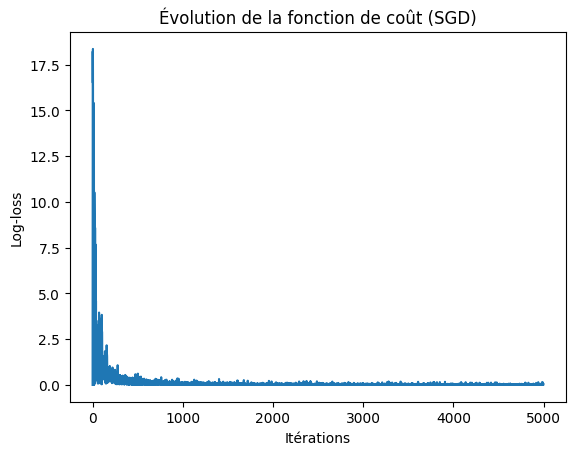

In [9]:
plt.plot(losses)
plt.xlabel("Itérations")
plt.ylabel("Log-loss")
plt.title("Évolution de la fonction de coût (SGD)")
plt.show()


**Observation :**  
La courbe de la fonction de coût est fortement instable.
Cela s’explique par le fait que le gradient est calculé à partir d’un seul échantillon
aléatoire à chaque itération, ce qui introduit du bruit dans la direction de descente.


## 3. Partie 2 : Régression sur California Housing

Ce dataset contient plus de 20 000 observations.
Calculer le gradient complet ici est coûteux, ce qui motive
l’usage du SGD.



### 3.1 Exercice 2 : Importance de la Standardisation

Le SGD est extrêmement sensible à l’échelle des données.


**Objectif :** Montrer que la standardisation des données améliore
la convergence du SGD.


### 3.1.2 Chargement et séparation des données

In [36]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

# Charger le dataset
X, y = fetch_california_housing(return_X_y=True)

# Split Train / Test
np.random.seed(42)
indices = np.random.permutation(len(X))
split = int(0.8 * len(X))

X_train, X_test = X[indices[:split]], X[indices[split:]]
y_train, y_test = y[indices[:split]], y[indices[split:]]


### 3.1.3 Fonctions utilitaires

In [37]:
def predict(X, w):
    return X @ w

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)


### 3.1.4 SGD sur données brutes (non standardisées)

In [38]:
n_samples, n_features = X_train.shape
w_raw = np.zeros(n_features)
alpha_raw = 1e-7  # très petit pour éviter divergence
n_epochs = 20
mse_raw = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        xi = X_train[i]
        yi = y_train[i]

        grad = 2 * (np.dot(xi, w_raw) - yi) * xi
        w_raw -= alpha_raw * grad

    mse_raw.append(mse(y_test, predict(X_test, w_raw)))


### 3.1.5 Standardisation des données

In [39]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_std = (X_train - mean) / std
X_test_std  = (X_test - mean) / std


### 3.1.6 SGD sur données standardisées

In [40]:
w_std = np.zeros(n_features)
alpha = 0.01  # plus grand que pour les données brutes
mse_std = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        xi = X_train_std[i]
        yi = y_train[i]

        grad = 2 * (np.dot(xi, w_std) - yi) * xi
        w_std -= alpha * grad

    mse_std.append(mse(y_test, predict(X_test_std, w_std)))


### 3.1.7 Analyse et visualisation

**Analyse :**
- Sans standardisation, les lignes de niveau de la fonction de coût
  sont très allongées → convergence lente.
- Avec standardisation, surface de coût plus isotrope → convergence plus rapide.


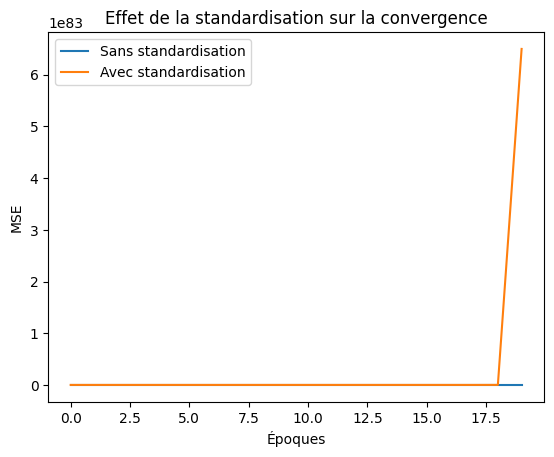

In [42]:
plt.plot(mse_raw, label="Sans standardisation")
plt.plot(mse_std, label="Avec standardisation")
plt.xlabel("Époques")
plt.ylabel("MSE")
plt.legend()
plt.title("Effet de la standardisation sur la convergence")
plt.show()


### 3.2 Exercice 3 : Mini-batch et Optimiseurs Modernes

Comparer l’évolution de la MSE pour :
1. SGD Pur (batch_size = 1)
2. Mini-batch SGD (batch_size = 32)
3. Adam (Optimiseur adaptatif)

Observation : lequel atteint le plateau de performance le plus rapidement ?


### 3.2.1 SGD Pur

In [43]:
w_sgd = np.zeros(n_features)
mse_sgd = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        xi = X_train_std[i]
        yi = y_train[i]

        grad = 2 * (np.dot(xi, w_sgd) - yi) * xi
        w_sgd -= alpha * grad

    mse_sgd.append(mse(y_test, predict(X_test_std, w_sgd)))


### 3.2.2 Mini-batch SGD (batch_size = 32)

In [46]:
w_mini = np.zeros(n_features)
batch_size = 32
mse_mini = []

for epoch in range(n_epochs):
    indices = np.random.permutation(n_samples)

    for start in range(0, n_samples, batch_size):
        batch = indices[start:start + batch_size]
        Xb = X_train_std[batch]
        yb = y_train[batch]

        grad = 2 * Xb.T @ (Xb @ w_mini - yb) / len(yb)
        w_mini -= alpha * grad

    mse_mini.append(mse(y_test, predict(X_test_std, w_mini)))


### 3.2.3 Optimiseur Adam

In [48]:
w_adam = np.zeros(n_features)
m = np.zeros(n_features)
v = np.zeros(n_features)

beta1, beta2 = 0.9, 0.999
eps = 1e-8
t = 0
mse_adam = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        t += 1
        xi = X_train_std[i]
        yi = y_train[i]

        grad = 2 * (np.dot(xi, w_adam) - yi) * xi

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2

        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        w_adam -= alpha * m_hat / (np.sqrt(v_hat) + eps)

    mse_adam.append(mse(y_test, predict(X_test_std, w_adam)))


### 3.2.4 Comparaison des performances

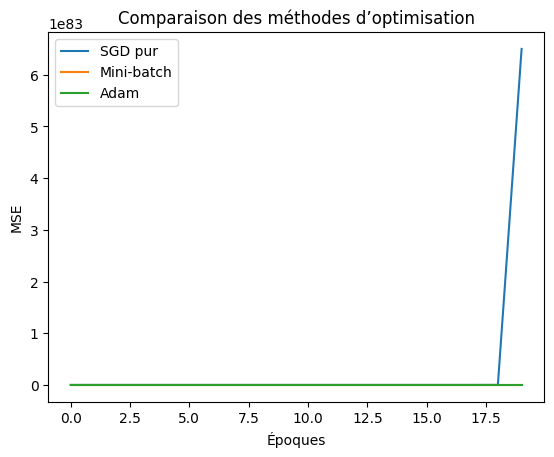

In [49]:
plt.plot(mse_sgd, label="SGD pur")
plt.plot(mse_mini, label="Mini-batch")
plt.plot(mse_adam, label="Adam")
plt.xlabel("Époques")
plt.ylabel("MSE")
plt.legend()
plt.title("Comparaison des méthodes d’optimisation")
plt.show()


**Observation :**  
Adam atteint le plateau le plus rapidement.  
Le mini-batch SGD est un bon compromis stabilité / coût de calcul.  
Le SGD pur est plus bruité.


## 4. Synthèse et Rapport

Dans cette section, nous répondons aux questions demandées par l’énoncé.


### 4.1 Pourquoi ne faut-il jamais utiliser un pas α trop grand ?

Si le pas α est trop grand, la mise à jour du poids peut dépasser le minimum
de la fonction de coût à chaque itération. Cela provoque :
- Des oscillations importantes autour du minimum
- Une divergence possible de l’algorithme
- Une instabilité générale dans la convergence

En pratique, il est crucial de choisir un α adapté pour garantir
une descente stable et progressive vers le minimum.


### 4.2 Avantage computationnel du Mini-batch sur GPU

Le mini-batch permet de traiter plusieurs échantillons simultanément.
Avantages :
- Exploitation optimale du parallélisme offert par les GPU
- Calcul matriciel plus efficace que le traitement d’un échantillon à la fois
- Convergence plus stable que le SGD pur
- Réduction du bruit dans la mise à jour des gradients


### 4.3 Concept de Shuffling

Le Shuffling consiste à mélanger les données à chaque époque.
Importance :
- Évite que l’algorithme suive un ordre particulier des données
- Réduit les biais dans la mise à jour des poids
- Améliore la convergence en rendant les gradients plus représentatifs
- Crucial pour le SGD pur et le mini-batch afin de stabiliser l’apprentissage
